In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("./Data/emotion2.tsv", sep="\t")
print(df.columns)

# Check for null values
null_idx = df[df["document"].isnull()].index
df.loc[null_idx]

# Split into train and test sets
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)
print("중복 제거 전 학습 데이터셋: {}".format(len(train_data)))
print("중복 제거 전 테스트 데이터셋: {}".format(len(test_data)))

# Remove duplicates
train_data = train_data.drop_duplicates(["document"])
test_data = test_data.drop_duplicates(["document"])
print("중복 제거 후 학습 데이터셋: {}".format(len(train_data)))
print("중복 제거 후 테스트 데이터셋: {}".format(len(test_data)))

# Tokenize the data
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_train_sentences = tokenizer(
    list(train_data['document']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True,
)

tokenizer_test_sentences = tokenizer(
    list(test_data['document']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True,
)

# Define dataset class
class CurseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_label = train_data['label'].values
test_label = test_data['label'].values

train_dataset = CurseDataset(tokenizer_train_sentences, train_label)
test_dataset = CurseDataset(tokenizer_test_sentences, test_label)
print(f"Number of evaluation samples: {len(test_dataset)}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

class LogHistory(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.history.append(logs.copy())  # logs를 복사해서 저장


log_history = LogHistory()

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }


# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[log_history],
)

Index(['document', 'label'], dtype='object')
중복 제거 전 학습 데이터셋: 4811
중복 제거 전 테스트 데이터셋: 1203
중복 제거 후 학습 데이터셋: 4796
중복 제거 후 테스트 데이터셋: 1199
Number of evaluation samples: 1199


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
trainer.train()

trainer.evaluate()

  0%|          | 0/225 [00:00<?, ?it/s]

C:\Users\jhy97\AppData\Local\Temp\ipykernel_22148\1044110119.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 1.0999, 'grad_norm': 0.5786473155021667, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.13}
{'loss': 1.1021, 'grad_norm': 0.6206623315811157, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.27}
{'loss': 1.0982, 'grad_norm': 0.6455625891685486, 'learning_rate': 3e-06, 'epoch': 0.4}
{'loss': 1.1025, 'grad_norm': 0.8508267402648926, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.53}
{'loss': 1.0988, 'grad_norm': 0.9164860248565674, 'learning_rate': 5e-06, 'epoch': 0.67}
{'loss': 1.09, 'grad_norm': 0.8144094347953796, 'learning_rate': 6e-06, 'epoch': 0.8}
{'loss': 1.0813, 'grad_norm': 0.7268959283828735, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.93}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 1.0613967180252075, 'eval_accuracy': 0.6305254378648875, 'eval_f1': 0.6191625470426436, 'eval_precision': 0.6246250324378978, 'eval_recall': 0.6305254378648875, 'eval_runtime': 2.5185, 'eval_samples_per_second': 476.081, 'eval_steps_per_second': 7.544, 'epoch': 1.0}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_22148\1044110119.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 1.0695, 'grad_norm': 0.9486463069915771, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.07}
{'loss': 1.0383, 'grad_norm': 1.3880879878997803, 'learning_rate': 9e-06, 'epoch': 1.2}
{'loss': 0.9864, 'grad_norm': 1.3538135290145874, 'learning_rate': 1e-05, 'epoch': 1.33}
{'loss': 0.9217, 'grad_norm': 8.313596725463867, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.47}
{'loss': 0.8608, 'grad_norm': 1.435362696647644, 'learning_rate': 1.2e-05, 'epoch': 1.6}
{'loss': 0.8008, 'grad_norm': 2.042985439300537, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.73}
{'loss': 0.7082, 'grad_norm': 2.057483434677124, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.87}
{'loss': 0.6442, 'grad_norm': 3.2563607692718506, 'learning_rate': 1.5e-05, 'epoch': 2.0}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.5620420575141907, 'eval_accuracy': 0.8473728106755629, 'eval_f1': 0.8457382646371141, 'eval_precision': 0.8474498265404308, 'eval_recall': 0.8473728106755629, 'eval_runtime': 2.5239, 'eval_samples_per_second': 475.054, 'eval_steps_per_second': 7.528, 'epoch': 2.0}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_22148\1044110119.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.5593, 'grad_norm': 3.206871509552002, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.13}
{'loss': 0.4927, 'grad_norm': 2.7233872413635254, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.27}
{'loss': 0.4814, 'grad_norm': 3.049011707305908, 'learning_rate': 1.8e-05, 'epoch': 2.4}
{'loss': 0.4182, 'grad_norm': 4.201098442077637, 'learning_rate': 1.9e-05, 'epoch': 2.53}
{'loss': 0.391, 'grad_norm': 4.291663646697998, 'learning_rate': 2e-05, 'epoch': 2.67}
{'loss': 0.4011, 'grad_norm': 2.1532227993011475, 'learning_rate': 2.1e-05, 'epoch': 2.8}
{'loss': 0.4074, 'grad_norm': 7.122232913970947, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.93}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.37775281071662903, 'eval_accuracy': 0.8657214345287739, 'eval_f1': 0.8653354877366456, 'eval_precision': 0.8652114376759393, 'eval_recall': 0.8657214345287739, 'eval_runtime': 2.5607, 'eval_samples_per_second': 468.234, 'eval_steps_per_second': 7.42, 'epoch': 3.0}
{'train_runtime': 121.9779, 'train_samples_per_second': 117.956, 'train_steps_per_second': 1.845, 'train_loss': 0.8017780929141575, 'epoch': 3.0}


C:\Users\jhy97\AppData\Local\Temp\ipykernel_22148\1044110119.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.37775281071662903,
 'eval_accuracy': 0.8657214345287739,
 'eval_f1': 0.8653354877366456,
 'eval_precision': 0.8652114376759393,
 'eval_recall': 0.8657214345287739,
 'eval_runtime': 2.6943,
 'eval_samples_per_second': 445.02,
 'eval_steps_per_second': 7.052,
 'epoch': 3.0}

In [48]:
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\tokenizer.json')

     loss  grad_norm  learning_rate     epoch  eval_loss  eval_accuracy  \
0  1.0999   0.578647       0.000001  0.133333        NaN            NaN   
1  1.1021   0.620662       0.000002  0.266667        NaN            NaN   
2  1.0982   0.645563       0.000003  0.400000        NaN            NaN   
3  1.1025   0.850827       0.000004  0.533333        NaN            NaN   
4  1.0988   0.916486       0.000005  0.666667        NaN            NaN   

   eval_f1  eval_precision  eval_recall  eval_runtime  \
0      NaN             NaN          NaN           NaN   
1      NaN             NaN          NaN           NaN   
2      NaN             NaN          NaN           NaN   
3      NaN             NaN          NaN           NaN   
4      NaN             NaN          NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                      NaN                    NaN            NaN   
2 

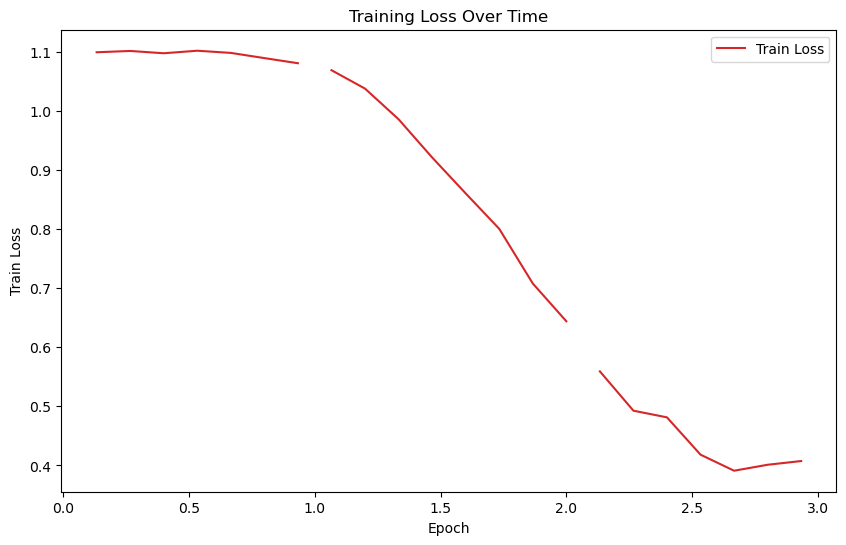

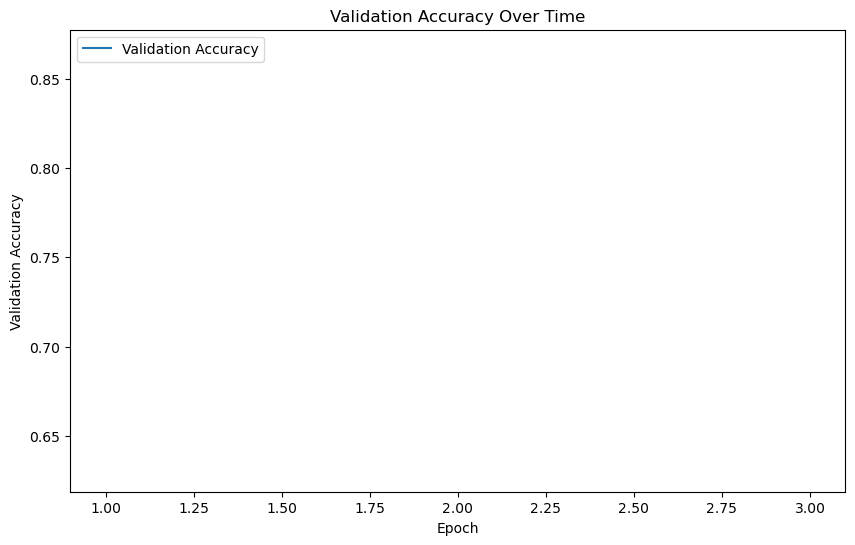

In [49]:
logs = pd.DataFrame(log_history.history)
print(logs.head())

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(logs['epoch'], logs['loss'], label='Train Loss', color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

# Plot validation accuracy
if 'eval_accuracy' in logs.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(logs['epoch'], logs['eval_accuracy'], label='Validation Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()
    plt.savefig('validation_accuracy.png')
    plt.show()
else:
    print("Warning: 'eval_accuracy' not found in logs.")

True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 1, Predicted Label: 1
True Label: 0, Predicted Label: 0
True Label: 2,

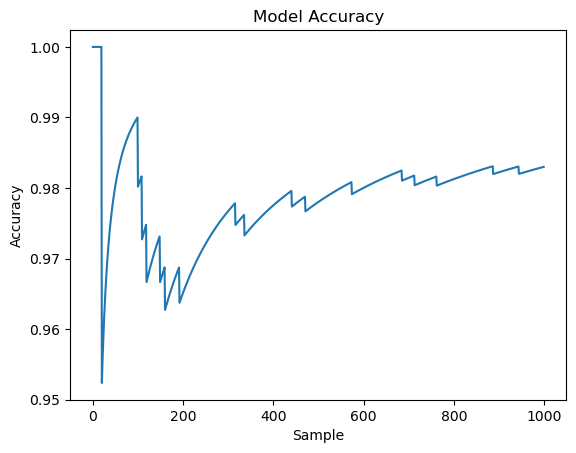

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# gpu 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 저장된 모델과 토크나이저 불러오기
model = AutoModelForSequenceClassification.from_pretrained("./saved_model")
tokenizer = AutoTokenizer.from_pretrained("./saved_model")

model.to(device)

# 문장 예측 함수
def sentence_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
        [sent],
        return_tensors="pt",
        max_length=128,
        padding=True,
        truncation=True,
        add_special_tokens=True,
    )
    tokenized_sent = {k: v.to(device) for k, v in tokenized_sent.items()}
    with torch.no_grad():
        outputs = model(
            input_ids=tokenized_sent["input_ids"],
            attention_mask=tokenized_sent["attention_mask"],
        )
    logits = outputs[0]
    logits = logits.detach().cpu()
    result = logits.argmax(-1).numpy()[0]
    return result

# 데이터 로드 및 샘플링
data = pd.read_csv("Data/emotion.tsv", sep='\t')
sampled_data = data.sample(n=1000)

# 정확도 계산을 위한 변수 초기화
correct_predictions = 0
accuracy_list = []

# 샘플 인덱스 관리
sample_index = 0

for index, row in sampled_data.iterrows():
    sentence = row['document']
    true_label = row['label']
    predicted_label = sentence_predict(sentence)
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    if true_label == predicted_label:
        correct_predictions += 1
    # 현재까지의 정확도를 리스트에 추가
    sample_index += 1
    accuracy_list.append(correct_predictions / sample_index)

accuracy = correct_predictions / len(sampled_data)
print(f"정확도: {accuracy * 100:.2f}%")

# 정확도 그래프 그리기
plt.plot(accuracy_list)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sample')
plt.savefig('accuracy_graph.png')  # 그래프를 파일로 저장
plt.show()  # 그래프를 화면에 표시
